# Cell Matching Across Days
Experimental sessions are conducted across multiple days on the same mouse. When imaging the brain location on the same plane with **2-Photon Imaging**, the image will not be perfectly identical. The frame may be in a slighlty different location on the brain or at a slighlty different depth. Additionally, cells can move relative to eachother over time. Due to this, computational methods are required to identify which cell *Regions of Interest* (ROIs) are the same as the previous session.

### Environment Setup

In [1]:
import os
import nway
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from PIL import Image
from pynwb import NWBHDF5IO


### Downloading Ophys NWB Files

In [2]:
dandiset_id = "000336"
dandi_filepath = "sub-1170622509/sub-1170622509_ses-1194683535-1194752574-_ophys.nwb"
download_loc = "."

authenticate = True
dandi_api_key = os.environ["dandi_api_key"]

In [ ]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

filename = dandi_filepath.split("/")[-1]
filepath = f"./{filename}"
file = my_dandiset.get_asset_by_path(dandi_filepath)

In [ ]:
# # this may take awhile, especially if the file to download is large
# file.download(filepath)

# print(f"Downloaded file to {filepath}")

In [3]:
io = NWBHDF5IO(f"{download_loc}/1193675753.nwb", mode="r", load_namespaces=True)
nwb1 = io.read()

io = NWBHDF5IO(f"{download_loc}/1194754135.nwb", mode="r", load_namespaces=True)
nwb2 = io.read()

nwbs = [nwb1, nwb2]

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
# these should be similar values
print(nwb1.lab_meta_data["metadata"].imaging_depth)
print(nwb2.lab_meta_data["metadata"].imaging_depth)

309
309


### Generating Cell-Matching Input File
The Allen Institute has created a robust pipeline for conducting cell matching between 2 or more sessions called [**Nway Matching**](https://github.com/AllenInstitute/ophys_nway_matching). For those who are inquisitive, the general algorithm is described in page 31 of [this Visual Behavior paper](https://www.biorxiv.org/content/10.1101/2023.02.14.528085v2.full.pdf). In summary, the input images are aligned together with a euclidian image registration technique. Then the given input ROI masks are used with the [Blossom Algorithm](https://en.wikipedia.org/wiki/Blossom_algorithm) as a bipartite graph matching algorithm. This identifies which ROIs represent the same cells with high probability.

The caveat to using this pipeline is that it requires input in a specific JSON format rather than an NWB File. The following functions are used to generate a file, `input.json`, which can be used to obtain important output. The input json contains an entry for each input experiment. 2 or more experiments can be used. The first experiment is called *fixed* and the other ones are *moving*. For each experiment, a unique experiment ID, a path to the experiment projection image, and a list of objects for each ROI are required.

In [5]:
def make_roi_entries(roi_table):
    roi_entries = []
    for roi_idx in range(len(roi_table)):
        x = int(roi_table["x"][roi_idx])
        y = int(roi_table["y"][roi_idx])
        height = int(roi_table["height"][roi_idx])
        width = int(roi_table["width"][roi_idx])
        
        mask_subimage = roi_table["image_mask"][roi_idx][y:y+height,x:x+width]
        
        roi_entry = {
            "id": int(roi_table["id"][roi_idx]),
            "valid": bool(roi_table["valid_roi"][roi_idx]),
            "x": x,
            "y": y,
            "z": 1,
            "width": width,
            "height": height,
            # convert 2D array to 2D list of bools
            "mask_matrix": [[bool(elem) for elem in row] for row in mask_subimage]
        }
        roi_entries.append(roi_entry)
    return roi_entries

In [6]:
def normalize_to_16b(image_array):
    image_array = image_array * 2**8
    return image_array.astype(np.uint16)

In [7]:
def nwb_to_experiment_json(nwb):
    # save image here
    grayscale_image = np.array(nwb.processing["ophys"]["images"]["average_image"])
    image_array = normalize_to_16b(np.array(grayscale_image))
    image_file = Image.fromarray(image_array)
    image_file = image_file.convert("L")
    image_file.save(f"./{nwb.identifier}_image.png")

    roi_table = nwb.processing["ophys"]["image_segmentation"]["cell_specimen_table"]
    
    experiment = {
        "id": nwb.identifier, 
        "ophys_average_intensity_projection_image": f"./{nwb.identifier}_image.png",
        "cell_rois": make_roi_entries(roi_table)
    }

    return experiment

In [8]:
input_exps = {
    "experiment_containers": {
        "ophys_experiments": []
    }
}

for nwb in nwbs:
    experiment = nwb_to_experiment_json(nwb)
    input_exps["experiment_containers"]["ophys_experiments"].append(experiment)

with open("input.json", "w") as f:
    json.dump(input_exps, f, indent=2)

### Running the Algorithm
**Nway Matching** can be run as a command with the following parameters. From there, several output files are generated.

In [9]:
!python -m nway.nway_matching --input_json input.json --output_json output.json --output_dir matching_output

INFO:NwayMatching:NWAY_COMMIT_SHA None
INFO:NwayMatching:Nway matching version 0.6.0
INFO:PairwiseMatching:Matching 1193675753 to 1194754135
INFO:PairwiseMatching:Matching 1193675753 to 1194754135: best registration was ['Crop', 'CLAHE', 'PhaseCorrelate']
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\nway\utils.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(0)
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\nway\utils.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(1)
INFO:NwayMatching:registration success(1) or failure (0):
   0  1
0  1  1
1  1  1
id map{
  "0": 1193675753,
  "1": 1194754135
}
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\nway\nway_matching.py:208: FutureWarning: The frame.append method is deprecated and 

### Showing Cell Matching Output
The cell matching pipeline outputs the data as a output JSON, and a few plots as `.png` images. The paths to the plots are fetched from the output JSON and displayed below. Additionally, the output json contains a list of matching ROI IDs from each image.

In [10]:
with open("output.json", "r") as f:
    output = json.load(f)

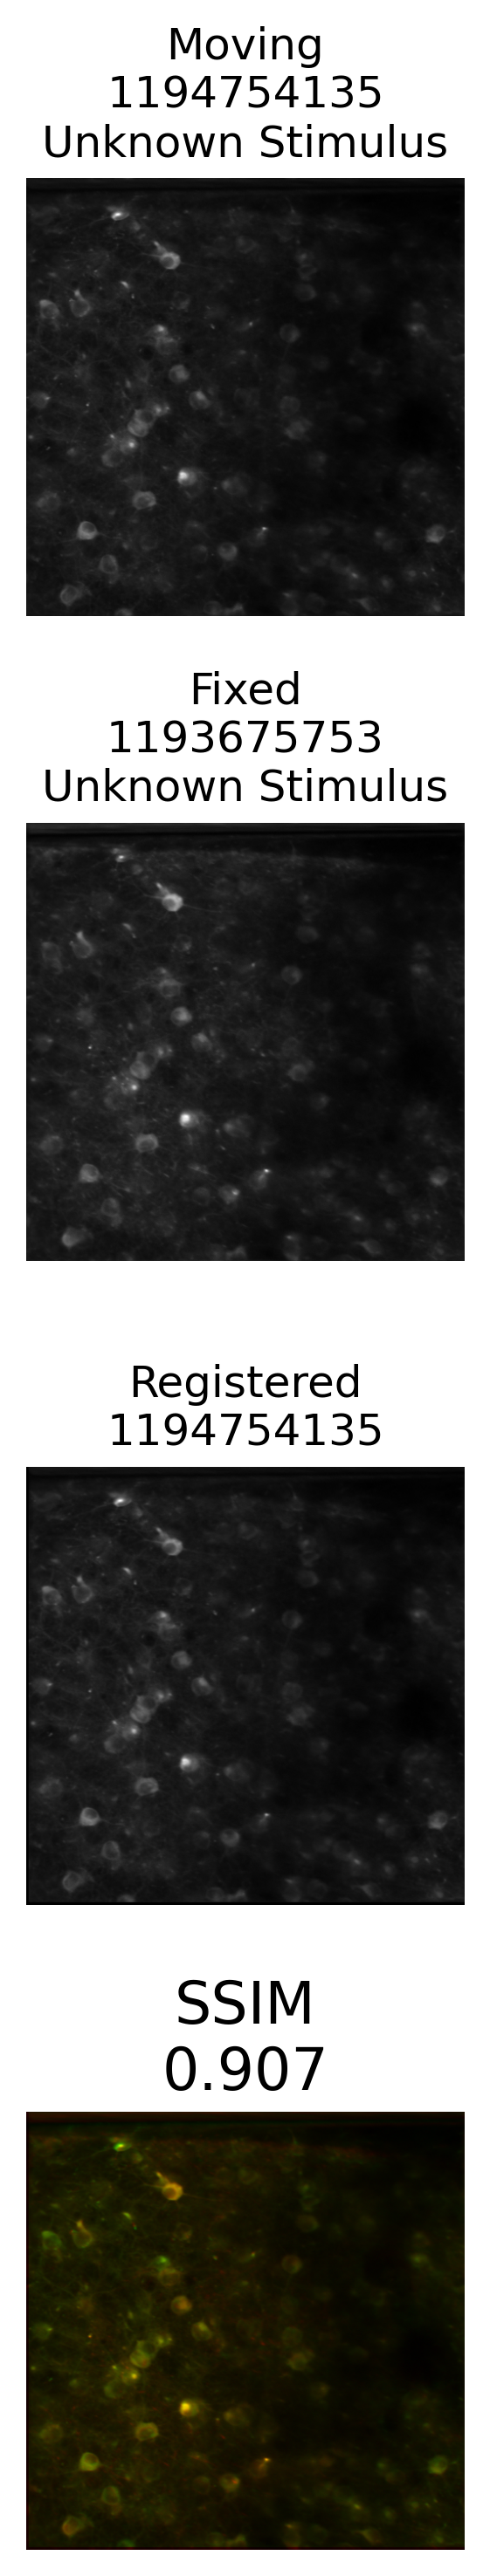

In [15]:
summary_plot = Image.open(output["nway_warp_summary_plot"])
summary_plot

In [13]:
overlay_plot = Image.open(output["nway_warp_overlay_plot"])
overlay_plot

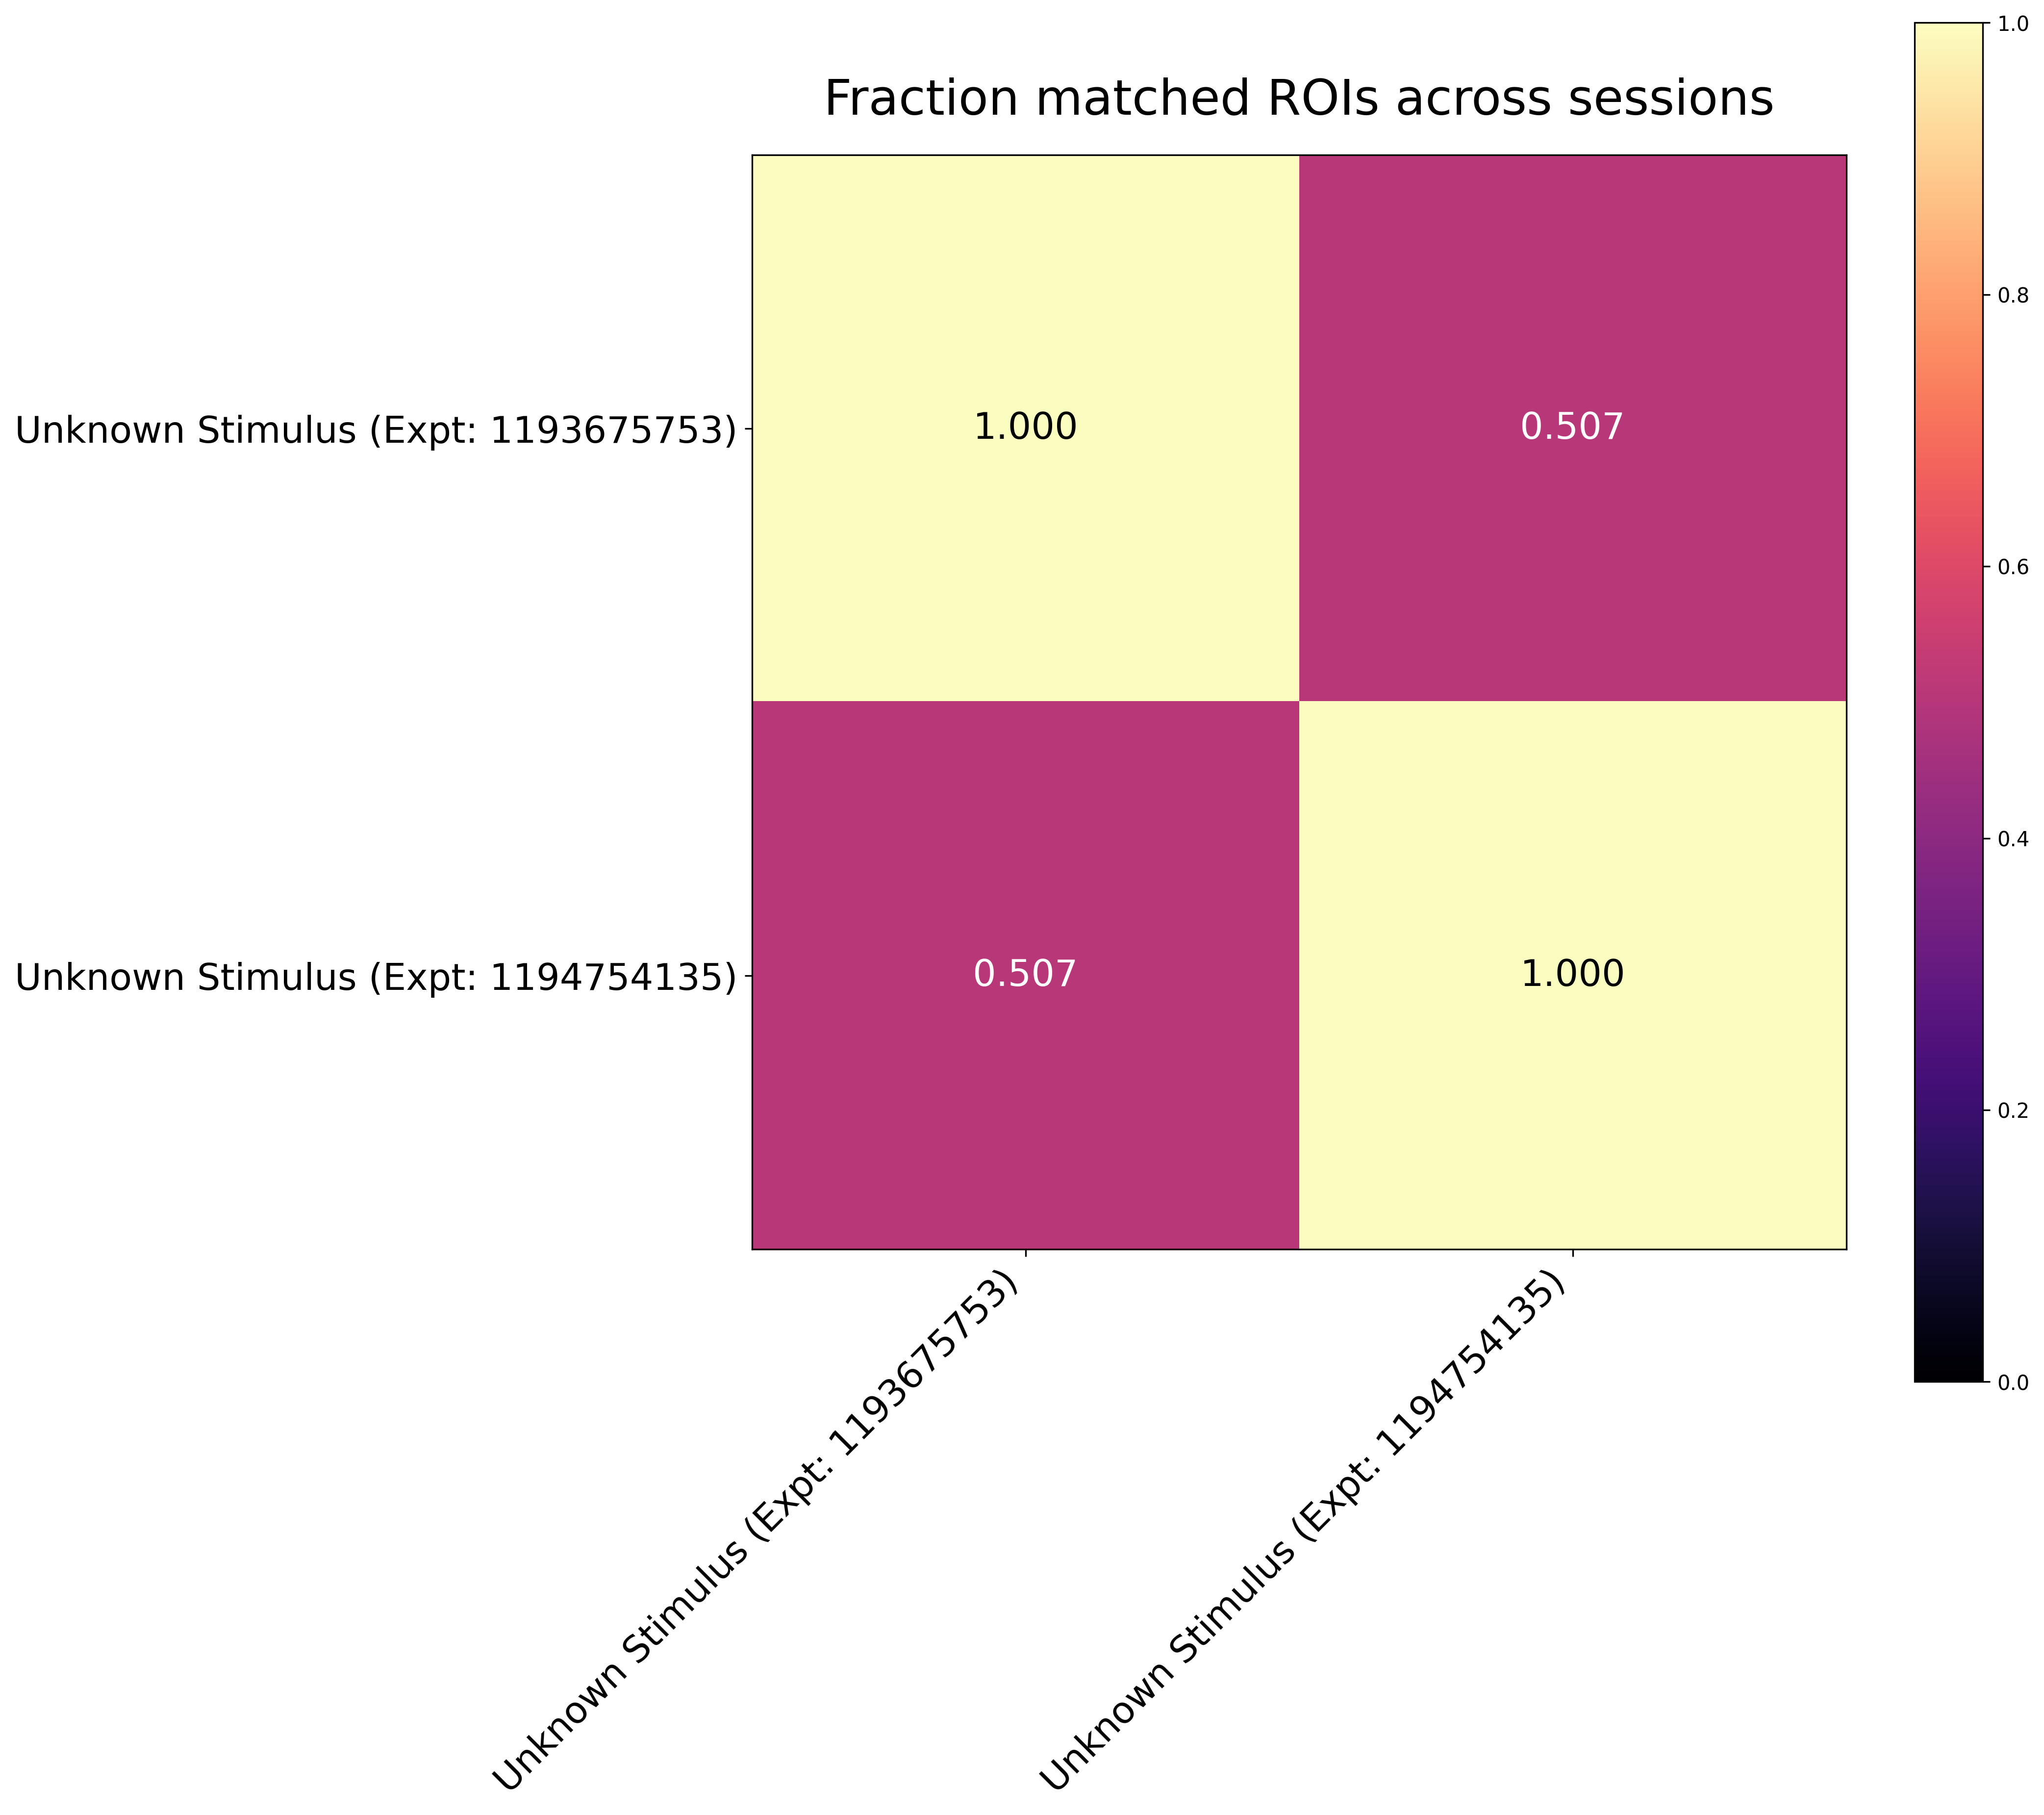

In [14]:
fraction_plot = Image.open(output["nway_match_fraction_plot"])
fraction_plot